In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

entity-annotated-corpus
wikiner-data




**Importing the dataset for named entity recognition model**

In [2]:
# dframe = pd.read_csv("../input/entity-annotated-corpus/ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)
f=open("../input/wikiner-data/aij-wikiner-fr-wp2.txt", "r")
data=[]
contents =f.readlines()
indx=0
for x in contents:
    words=x.split()
#     print(len(words))
    for i in range(len(words)):
        
        tags=words[i].split("|")
#         print(len(tags))
        data.append([indx,tags[0],tags[2]])
#     print(words)
    indx+=1
wikiner_data= pd.DataFrame(data, columns=['sentence', 'word', 'tag'])

In [3]:
wikiner_data.head(20)

,sentence,word,tag
0,1,Il,O
1,1,assure,O
2,1,à,O
3,1,la,O
4,1,suite,O
5,1,de,I-PER
6,1,Saussure,I-PER
7,1,le,O
8,1,cours,O
9,1,de,O


In [4]:
wikiner_data.head()

,sentence,word,tag
0,1,Il,O
1,1,assure,O
2,1,à,O
3,1,la,O
4,1,suite,O


> **Create list of list of tuples to differentiate each sentence from each other**

In [5]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                       
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [6]:
getter = SentenceGetter(wikiner_data)

In [7]:
sentences = getter.sentences

In [8]:
maxlen = max([len(s) for s in sentences])
print ('Maximum sequence length:', maxlen)

Maximum sequence length: 242


In [9]:
# Check how long sentences are so that we can pad them
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

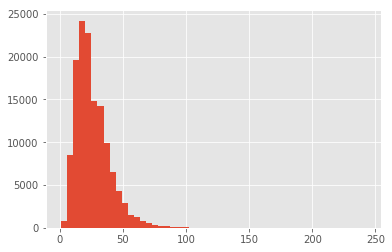

In [10]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [11]:
words = list(set(wikiner_data["word"].values))
words.append("ENDPAD")

In [12]:
n_words = len(words); n_words

116487

In [13]:
tags = list(set(wikiner_data["tag"].values))

In [14]:
n_tags = len(tags); n_tags

9

**Converting words to numbers and numbers to words**

In [15]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [16]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sentences]

Using TensorFlow backend.


In [17]:
X = pad_sequences(maxlen=242, sequences=X, padding="post",value=n_words - 1)

In [18]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]

In [19]:
y = pad_sequences(maxlen=242, sequences=y, padding="post", value=tag2idx["O"])

In [20]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [22]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

In [26]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-4d431gv_
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-4d431gv_
  Stored in directory: /tmp/pip-ephem-wheel-cache-dudv18t0/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


In [28]:
from keras_contrib.layers import CRF
input = Input(shape=(242,))
model = Embedding(input_dim=n_words, output_dim=242, input_length=242)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output
model = Model(input, out)

In [29]:
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()

/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/opt/conda/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 242)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 242, 242)          28189854  
_________________________________________________________________
dropout_4 (Dropout)          (None, 242, 242)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 242, 200)          274400    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 242, 9)            1809      
_________________________________________________________________
crf_1 (CRF)                  (None, 242, 9)            189       
Total params: 28,466,252
Trainable params: 28,466,252
Non-trainable params: 0
________________________________________________________________

In [ ]:
history = model.fit(X_train, np.array(y_train), batch_size=512, epochs=5, validation_split=0.2, verbose=1)

Train on 85818 samples, validate on 21455 samples
Epoch 1/5
85818/85818 [==============================] - 1119s 13ms/step - loss: 0.7136 - crf_viterbi_accuracy: 0.9814 - val_loss: 0.4129 - val_crf_viterbi_accuracy: 0.9873
Epoch 2/5
29184/85818 [=========>....................] - ETA: 11:22 - loss: 0.3472 - crf_viterbi_accuracy: 0.9872

In [ ]:
i = 1
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w,pred in zip(X_test[i],p[0]):
    print("{:15}: {}".format(words[w],tags[pred]))

In [ ]:
idx2tag = {i: w for w, i in tag2idx.items()}

def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

In [ ]:
!pip3 install seqeval

In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [ ]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))


In [ ]:
!pip install sklearn_crfsuite

In [ ]:
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

In [ ]:
# i = 231
# p = model.predict(np.array(te))
# p = np.argmax(p, axis=-1)
# print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
# for w, pred in zip(te[0], p[0]):
#     print("{:15}: {}".format(words[w], tags[pred]))

In [ ]:
# max_len = 242
# max_len_char = 10
# word2idx = {w: i + 2 for i, w in enumerate(words)}
# word2idx["UNK"] = 1
# word2idx["PAD"] = 0
# idx2word = {i: w for w, i in word2idx.items()}
# tag2idx = {t: i + 1 for i, t in enumerate(tags)}
# tag2idx["PAD"] = 0
# idx2tag = {i: w for w, i in tag2idx.items()}

In [ ]:
# print(word2idx["Obama"])
# print(tag2idx)

In [ ]:
# from keras.preprocessing.sequence import pad_sequences
# X_word = [[word2idx[w[0]] for w in s] for s in sentences]
# X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')
# chars = set([w_i for w in words for w_i in w])
# n_chars = len(chars)
# char2idx = {c: i + 2 for i, c in enumerate(chars)}
# char2idx["UNK"] = 1
# char2idx["PAD"] = 0

In [ ]:
# %%time
# X_char = []
# for sentence in sentences:
#     sent_seq = []
#     for i in range(max_len):
#         word_seq = []
#         for j in range(max_len_char):
#             try:
#                 word_seq.append(char2idx.get(sentence[i][0][j]))
#             except:
#                 word_seq.append(char2idx.get("PAD"))
#         sent_seq.append(word_seq)
#     X_char.append(np.array(sent_seq))

In [ ]:
# y = [[tag2idx[w[1]] for w in s] for s in sentences]
# y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')


In [ ]:
# from sklearn.model_selection import train_test_split
# X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
# X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)


In [ ]:
# from keras.models import Model, Input
# from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
# from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D
# # input and embedding for words
# word_in = Input(shape=(max_len,))
# emb_word = Embedding(input_dim=n_words + 2, output_dim=100,
#                      input_length=max_len, mask_zero=True)(word_in)

# # input and embeddings for characters
# char_in = Input(shape=(max_len, max_len_char,))
# emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=100,
#                            input_length=max_len_char, mask_zero=True))(char_in)
# # character LSTM to get word encodings by characters
# char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
#                                 recurrent_dropout=0.5))(emb_char)

# # main LSTM
# x = concatenate([emb_word, char_enc])
# x = SpatialDropout1D(0.3)(x)
# main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
#                                recurrent_dropout=0.6))(x)
# out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)

# model = Model(inputs=[word_in, char_in], out)


In [ ]:
# model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
# model.summary()


In [ ]:
# x_char=np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))
# y_out=np.array(y_tr).reshape(len(y_tr), max_len, 1)

In [ ]:
# history = model.fit([X_word_tr, x_char],[y_out],batch_size=64, epochs=5, validation_split=0.3, verbose=1)

In [ ]:
# hist = pd.DataFrame(history.history)


In [ ]:
# import matplotlib.pyplot as plt
# plt.style.use("ggplot")
# plt.figure(figsize=(12,12))
# plt.plot(hist["acc"])
# plt.plot(hist["val_acc"])
# plt.show()

In [ ]:
# y_pred = model.predict([X_word_te,
#                         np.array(X_char_te).reshape((len(X_char_te),
#                                                      max_len, max_len_char))])


In [ ]:
# i = 1925
# p = np.argmax(y_pred[i], axis=-1)
# print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
# print(30 * "=")
# for w, t, pred in zip(X_word_te[i], y_te[i], p):
#     if w != 0:
#         print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))
